In [1]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2, RealAmplitudes
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Session, Estimator
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import COBYLA
import numpy as np
from qiskit import Aer
from qiskit.providers.aer import AerSimulator
from qiskit.utils import QuantumInstance
from qiskit.algorithms.minimum_eigensolvers import VQE
import pandas as pd

C:\Users\dienr\AppData\Local\Temp\ipykernel_4760\2947959449.py:4: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver


# HAMILTONIANA
$$H(J)=\sum_{i=1}^N\sigma_i^z - J\cdot\sum_{i=1}^N\sigma_i^x\sigma_{i+1}^x$$

In [2]:
from qiskit.quantum_info import Operator, Pauli ,DensityMatrix
from qiskit.opflow import Z, I, X

def hamilton_flow(N,J):
    
    for i in range(N):
        hisZ = Z
        hisZ = I^(i)^hisZ
        hisZ = hisZ ^(I^(N-1-i))
        if(i==0): ham = hisZ
        else: ham += hisZ
    for i in range(N-1):
        hisX = X^X
        hisX = I^(i)^hisX
        hisX = hisX ^(I^(N-2-i))
        ham += (-J)*hisX
    hisX_N = X^(I^(N-2))^X
    ham += (-J)*hisX_N

    return (ham)
print(hamilton_flow(5,0.5))

1.0 * ZIIII
+ 1.0 * IZIII
+ 1.0 * IIZII
+ 1.0 * IIIZI
+ 1.0 * IIIIZ
- 0.5 * XXIII
- 0.5 * IXXII
- 0.5 * IIXXI
- 0.5 * IIIXX
- 0.5 * XIIIX


# ANSATZ E ISTANZIAZIONE VQE

c:\Users\dienr\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


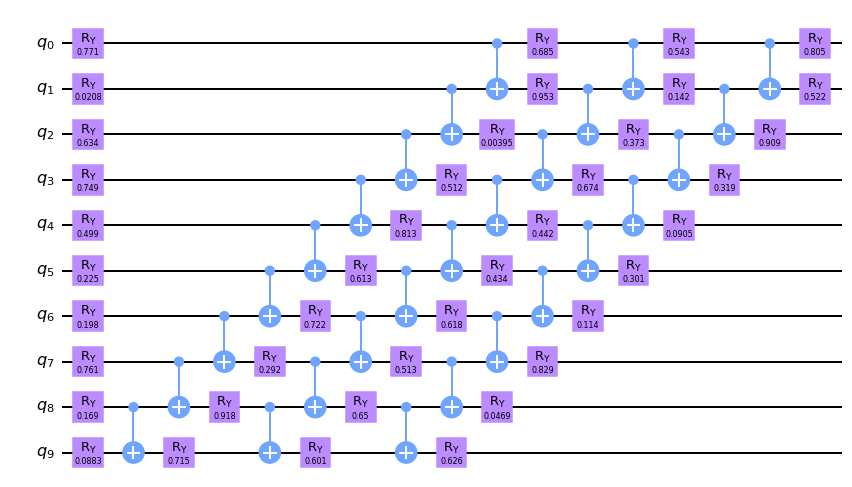

In [3]:

# seed per riproducibilità
np.random.seed(10)  

# taglia N della catena, ansatz, ottimizzatore e prova di inizializzaione 
N = 10
ansatz = RealAmplitudes(num_qubits=N, reps=3)
ottimizzatore = COBYLA(maxiter=1000)

inizio = np.random.random(ansatz.num_parameters)

prova = ansatz.assign_parameters(inizio)
prova.decompose().draw('mpl')

## FUNZIONE DI CALLBACK

In [4]:
from dataclasses import dataclass

@dataclass
class VQELog:
    values: list
    parameters: list

    def update(self, count, parameters, mean, _metadata):
        self.values.append(mean)
        self.parameters.append(parameters)
        print(f"Running circuit {count} of ~1000", end="\r", flush=True)
    
    # da utilizzare quando la VQE viene ripetuta più volte di fila 
    def azzera(self):
        self.parameters = []
        self.values = []

log = VQELog([], [])


# VQE

In [5]:
# importo simulatore locale e VQE
from qiskit.providers.basicaer import QasmSimulatorPy  
from qiskit.algorithms import VQE

simultore = Aer.get_backend("statevector_simulator")

local_vqe = VQE(ansatz=ansatz,
                optimizer=ottimizzatore,
                initial_point=inizio,
                # quantum_instance=QasmSimulatorPy(),
                quantum_instance= simultore,
                callback=log.update)

C:\Users\dienr\AppData\Local\Temp\ipykernel_4760\3881623794.py:7: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  local_vqe = VQE(ansatz=ansatz,


## CICLO E SALVATAGGIO

In [6]:
dataset = pd.DataFrame(index=None)

ciclo = np.linspace(0.75,1.25,200)


indice=0
for J in ciclo:
    indice += 1
    risultati = local_vqe.compute_minimum_eigenvalue(hamilton_flow(N,J))
    sol_numpy = NumPyMinimumEigensolver().compute_minimum_eigenvalue(hamilton_flow(N,J))
    energia = log.values[-1]

    # per ciascuna riga il primo dato stampato è J
    stato = np.array([J])
    
    # poi l'autovalore proveninente dalla VQE e l'energia "effettiva" calcolata con numpy
    stato = np.append(stato,[energia,sol_numpy.eigenvalue])

    # infine i parametri del circuito
    stato = np.append(stato,np.array(log.parameters[-1]))
    datastato = pd.DataFrame([stato])
    dataset = pd.concat([dataset,datastato])
    
    # pulizia log per ciclo successivo
    log.azzera()

    # stampa di controllo
    print(f'\n--------------------Sono arrivato a {J}--------------------\n')
    if((int(indice)%50)==0): dataset.to_csv('dataset/dataset.csv',index=[])
    
dataset.to_csv('dataset/dataset_prova.csv',index=[])

Running circuit 1000 of ~191
--------------------Sono arrivato a 0.75--------------------

Running circuit 1000 of ~191
--------------------Sono arrivato a 0.7525125628140703--------------------

Running circuit 1000 of ~191
--------------------Sono arrivato a 0.7550251256281407--------------------

Running circuit 1000 of ~191
--------------------Sono arrivato a 0.757537688442211--------------------

Running circuit 1000 of ~191
--------------------Sono arrivato a 0.7600502512562815--------------------

Running circuit 1000 of ~191
--------------------Sono arrivato a 0.7625628140703518--------------------

Running circuit 1000 of ~191
--------------------Sono arrivato a 0.7650753768844221--------------------

Running circuit 1000 of ~191
--------------------Sono arrivato a 0.7675879396984925--------------------

Running circuit 1000 of ~191
--------------------Sono arrivato a 0.7701005025125628--------------------

Running circuit 1000 of ~191
--------------------Sono arrivato a 0.772

In [7]:
# prova di lettura

data_prova = pd.read_csv('dataset/dataset_prova.csv')
data_prova

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.750000,-11.130466,-11.472140,2.413566,0.024398,1.743248,0.065364,0.698518,-0.127520,0.003819,...,-0.408645,-0.230950,-0.099420,-0.000757,0.064980,0.230704,0.528811,0.807310,0.913627,0.970429
1,0.752513,-11.164019,-11.482670,1.922310,0.208721,1.499250,0.498914,0.910883,-0.641320,0.749561,...,0.125385,0.092937,0.074417,0.149891,0.198028,0.257710,0.425130,0.857994,1.372633,1.655166
2,0.755025,-11.096387,-11.493249,1.954351,0.326292,1.888289,0.590160,0.516225,-0.449395,0.262871,...,-0.470966,-0.243430,-0.085599,0.021765,0.153037,0.420242,0.742017,0.829915,0.854768,0.922302
3,0.757538,-11.123327,-11.503875,2.748185,-0.012600,1.582958,0.000352,1.096085,0.219425,0.025421,...,-0.450119,-0.271335,-0.130034,-0.040555,0.096141,0.367290,0.705893,0.807556,0.863112,0.904639
4,0.760050,-11.128924,-11.514550,2.755782,-0.027055,1.608058,0.021930,0.760731,0.136564,0.014305,...,-0.483770,-0.326688,-0.211600,-0.118226,0.090102,0.487609,0.733724,0.784007,0.824299,0.882733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.239950,-14.451194,-14.533180,0.091434,0.065992,0.149782,0.509456,0.167541,0.222538,-0.258410,...,0.764328,1.476669,0.481965,0.044813,0.100046,0.436145,0.422993,0.415176,0.413994,0.419551
196,1.242462,-14.473173,-14.553261,0.090761,0.067302,0.153356,0.653227,0.136084,0.255124,-0.227282,...,0.867555,1.366566,0.491865,0.129195,-0.074469,0.435475,0.425664,0.414358,0.414088,0.418084
197,1.244975,-14.492786,-14.573370,0.096136,0.085537,0.141263,0.682798,0.080357,0.152382,-0.135674,...,0.903638,1.095526,0.594279,0.253011,0.172029,0.436958,0.415545,0.413239,0.411084,0.412414
198,1.247487,-14.514437,-14.593507,0.095561,0.076394,0.111776,0.649748,0.151784,0.129214,-0.004009,...,0.938125,1.430677,0.466009,0.416026,0.248530,0.428524,0.419324,0.411978,0.410072,0.412162
